# Oil search ⛽

Компании «ГлавРосГосНефть» необходимо решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
1) В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2) Строят модель для предсказания объёма запасов в новых скважинах;
3) Выбирают скважины с самыми высокими оценками значений;
4) Определяют регион с максимальной суммарной прибылью отобранных скважин.


Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Требуется построить модель для определения региона, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски с помощью техники *Bootstrap*.

**Содержание**<a id='toc0_'></a>    
1. [Подготовка       ](#toc1_)    
1.1. [Библиотеки       ](#toc1_1_)    
1.2. [Конфигурация       ](#toc1_2_)    
1.3. [Сервисные функции       ](#toc1_3_)    
2. [Данные о скважине 0       ](#toc2_)    
2.1. [Загрузка      ](#toc2_1_)    
2.2. [Проверка типов данных      ](#toc2_2_)    
2.3. [Обработка дубликатов      ](#toc2_3_)    
2.4. [Проверка пропусков      ](#toc2_4_)    
2.5. [Изучение столбцов      ](#toc2_5_)    
2.5.1. [Столбец `f0`      ](#toc2_5_1_)    
2.5.2. [Столбец `f1`      ](#toc2_5_2_)    
2.5.3. [Столбец `f2`      ](#toc2_5_3_)    
2.5.4. [Столбец `product`      ](#toc2_5_4_)    
2.6. [Проверка корреляции    ](#toc2_6_)    
2.7. [Проверка мультиколлинеарности    ](#toc2_7_)    
2.8. [Выводы по датасету     ](#toc2_8_)    
3. [Данные о скважине 1     ](#toc3_)    
3.1. [Загрузка     ](#toc3_1_)    
3.2. [Проверка типов данных     ](#toc3_2_)    
3.3. [Обработка дубликатов     ](#toc3_3_)    
3.4. [Проверка пропусков     ](#toc3_4_)    
3.5. [Изучение столбцов     ](#toc3_5_)    
3.5.1. [Столбец `f0`     ](#toc3_5_1_)    
3.5.2. [Столбец `f1`     ](#toc3_5_2_)    
3.5.3. [Столбец `f2`     ](#toc3_5_3_)    
3.5.4. [Столбец `product`     ](#toc3_5_4_)    
3.6. [Проверка корреляции   ](#toc3_6_)    
3.7. [Проверка мультиколлинеарности   ](#toc3_7_)    
3.8. [Выводы по датасету     ](#toc3_8_)    
4. [Данные о скважине 2     ](#toc4_)    
4.1. [Загрузка     ](#toc4_1_)    
4.2. [Проверка типов данных     ](#toc4_2_)    
4.3. [Обработка дубликатов     ](#toc4_3_)    
4.4. [Обработка пропусков     ](#toc4_4_)    
4.5. [Изучение столбцов     ](#toc4_5_)    
4.5.1. [Столбец `f0`     ](#toc4_5_1_)    
4.5.2. [Столбец `f1`     ](#toc4_5_2_)    
4.5.3. [Столбец `f2`     ](#toc4_5_3_)    
4.5.4. [Столбец `product`     ](#toc4_5_4_)    
4.6. [Проверка корреляции  ](#toc4_6_)    
4.7. [Проверка мультиколлинеарности  ](#toc4_7_)    
4.8. [Выводы по датасету     ](#toc4_8_)    
5. [Расчёт прибыли    ](#toc5_)    
6. [Общий вывод](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка        [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки        [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else:
    pass
    %pip install --upgrade -q numpy

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade -q phik
%pip install --upgrade -q prettytable
%pip install --upgrade -q termcolor
%pip install --upgrade -q seaborn
%pip install --upgrade -q pandas
%pip install --upgrade -q statsmodels
%pip install --upgrade -q scikit-learn

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os.path import exists

# preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler)

# models
from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from phik import phik_matrix  # this import IS accessed
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### 1.2. <a id='toc1_2_'></a>Конфигурация        [&#8593;](#toc0_)

In [4]:
RANDOM_STATE = 27
TEST_SIZE = 0.25

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### 1.3. <a id='toc1_3_'></a>Сервисные функции        [&#8593;](#toc0_)

In [5]:
def print_table_about_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [6]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str,
                            bins: int = 20
                            ) -> None:
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

In [7]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue

        try:
            df = pd.read_csv(_path)
        except:
            continue

        if df is None:
            continue

        return df

    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [8]:
def get_plots_about_residuals(y_true: np.array, y_pred: np.array) -> None:
    res = y_true - y_pred

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    sns.histplot(res, ax=ax1)
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.axvline(x=0, color='green', lw=3, ls='-', label='Нулевое значение')
    ax1.axvline(x=res.mean(), color='red', lw=3, ls='--', label='Среднее значение остатков')
    ax1.legend()

    sns.scatterplot(x=y_pred, y=res, ax=ax2)
    ax2.set_xlabel('Предсказанные значение')
    ax2.set_ylabel('Остатки')

    fig.suptitle('Информация об остатках')

In [9]:
def check_vif_values(df: pd.DataFrame, num_cols: list[str]) -> pd.DataFrame:
    scaler = StandardScaler()
    df_for_vif = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

    with_constants = add_constant(df_for_vif)

    vif_data = pd.DataFrame()
    vif_data["Variable"] = with_constants.columns
    vif_data["VIF"] = [variance_inflation_factor(with_constants.values, i) for i in range(with_constants.shape[1])]

    return vif_data.sort_values(by='VIF')

In [10]:
def predict_result(df: pd.DataFrame, target: str) -> tuple[pd.Series, pd.Series]:
    X, y = df.drop(columns=target), df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f'Средний запас предсказанного сырья = {y_pred.mean():5.2f}')
    print(f'                              RMSE = {rmse:5.2f}')

    y_test = y_test.reset_index(drop=True)
    return y_test, pd.Series(y_pred, name='product')

## 2. <a id='toc2_'></a>Данные о скважине 0        [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка       [&#8593;](#toc0_)

In [11]:
# dataset is not presented due to copyright
df0 = get_dataframe(['./data/geo_data_0.csv'])

df0.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


### 2.2. <a id='toc2_2_'></a>Проверка типов данных       [&#8593;](#toc0_)

In [12]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Типы данных указаны верно во всех столбцах.

### 2.3. <a id='toc2_3_'></a>Обработка дубликатов       [&#8593;](#toc0_)

In [13]:
df0.duplicated().sum()

0

Полных дубликатов нет. Столбец `id` не несет практической пользы, поэтому избавимся от него и снова проверим не появились ли дубликаты.

In [14]:
df0 = df0.drop(columns='id')

In [15]:
df0.duplicated().sum()

0

### 2.4. <a id='toc2_4_'></a>Проверка пропусков       [&#8593;](#toc0_)

In [16]:
print_table_about_nans(df0)

+---------+----------------------+
| Feature | Missing values count |
+---------+----------------------+
|    f0   |      0 (0.00%)       |
|    f1   |      0 (0.00%)       |
|    f2   |      0 (0.00%)       |
| product |      0 (0.00%)       |
+---------+----------------------+


Датасет не содержит пропусков.

### 2.5. <a id='toc2_5_'></a>Изучение столбцов       [&#8593;](#toc0_)

#### 2.5.1. <a id='toc2_5_1_'></a>Столбец `f0`       [&#8593;](#toc0_)

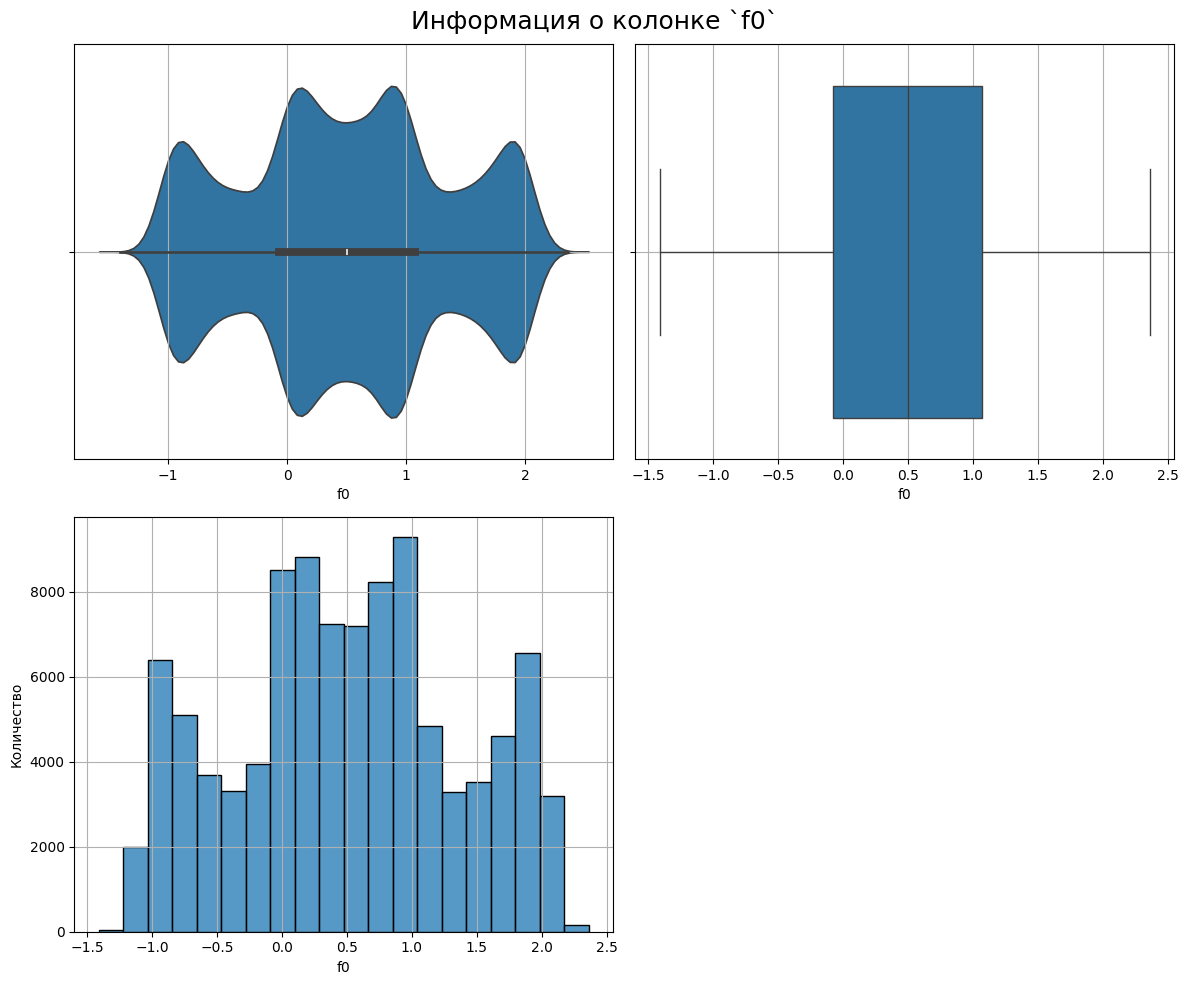

In [17]:
draw_plots_about_column(df0, 'f0', 'f0')

#### 2.5.2. <a id='toc2_5_2_'></a>Столбец `f1`       [&#8593;](#toc0_)

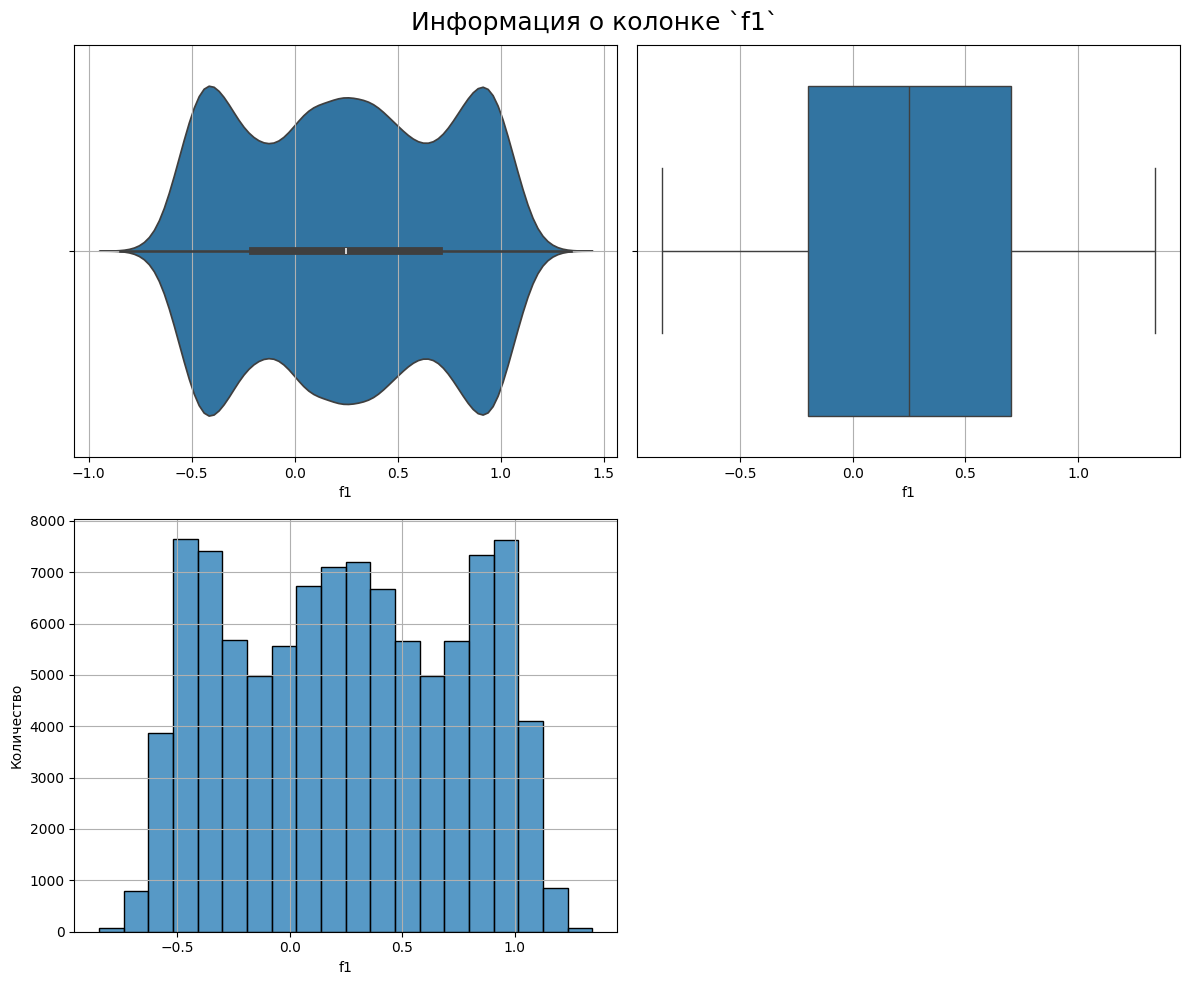

In [18]:
draw_plots_about_column(df0, 'f1', 'f1')

#### 2.5.3. <a id='toc2_5_3_'></a>Столбец `f2`       [&#8593;](#toc0_)

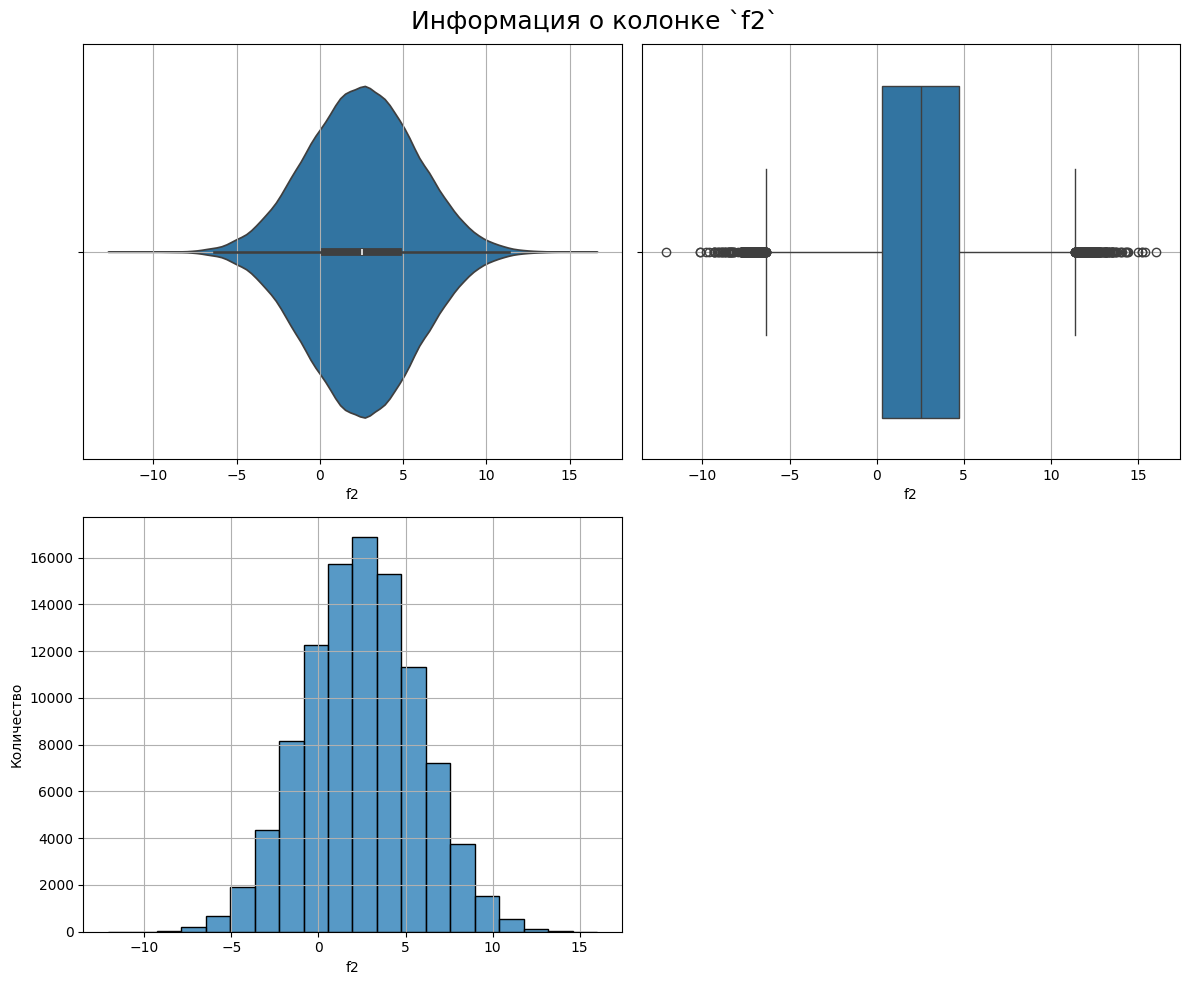

In [19]:
draw_plots_about_column(df0, 'f2', 'f2')

#### 2.5.4. <a id='toc2_5_4_'></a>Столбец `product`       [&#8593;](#toc0_)

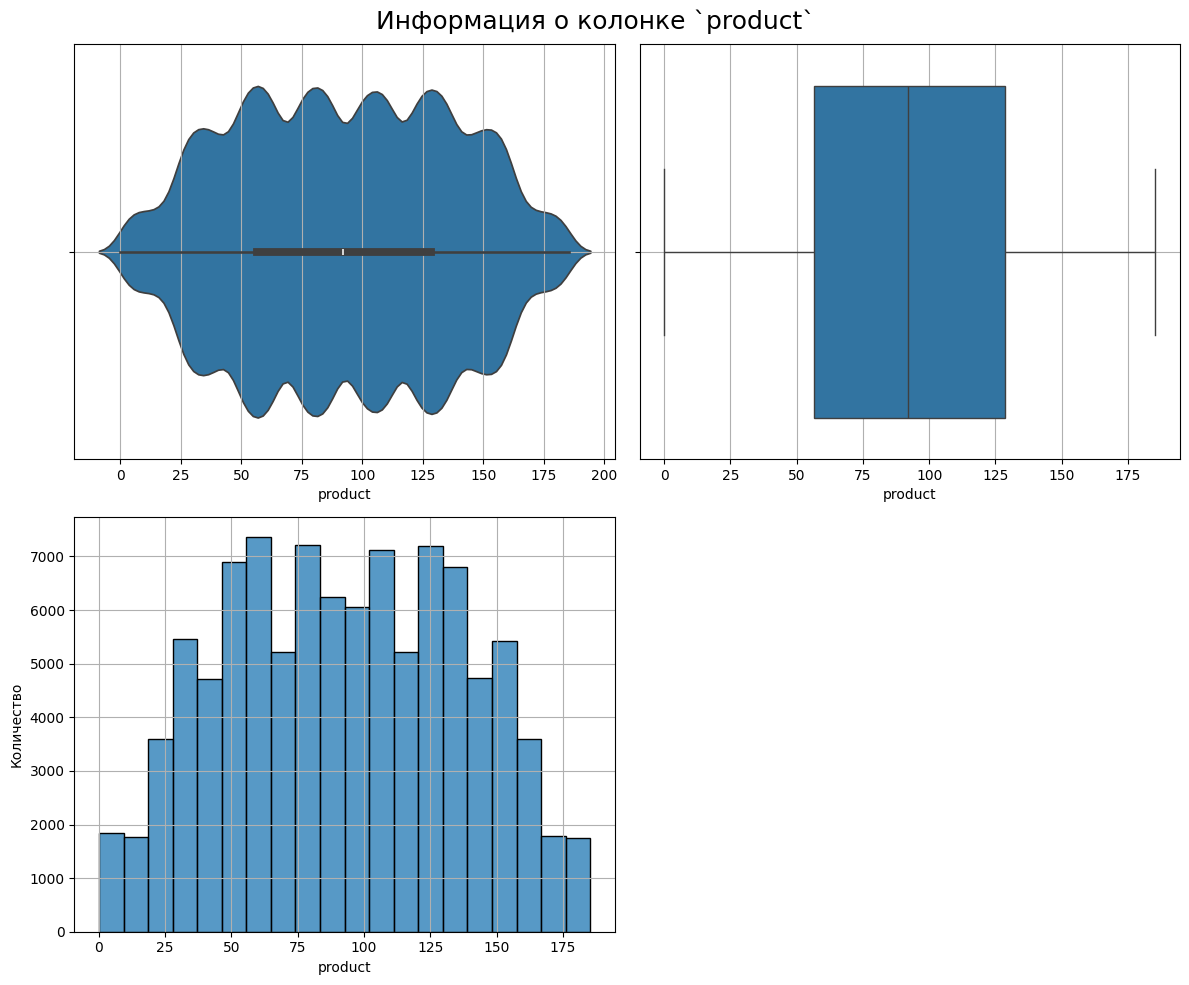

In [20]:
draw_plots_about_column(df0, 'product', 'product')

### 2.6. <a id='toc2_6_'></a>Проверка корреляции     [&#8593;](#toc0_)

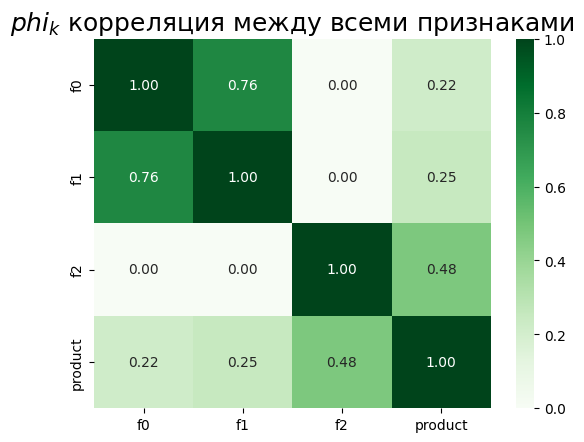

In [21]:
sns.heatmap(
    df0.phik_matrix(interval_cols=df0.columns),
    cmap='Greens',
    annot=True,
    fmt='.2f');

plt.title(r'$phi_k$ корреляция между всеми признаками', fontsize=18);

### 2.7. <a id='toc2_7_'></a>Проверка мультиколлинеарности     [&#8593;](#toc0_)

In [22]:
check_vif_values(df0, df0.columns)

,Variable,VIF
0,const,1.00
1,f0,1.25
2,f1,1.28
3,f2,1.32
4,product,1.38


### 2.8. <a id='toc2_8_'></a>Выводы по датасету      [&#8593;](#toc0_)

Датасет содержит информацию о скважинах в регионе 0. Датасет не имеет пропусков и полных дубликатов. Столбец `id` был удален, так как не несет никакой пользы. Все остальные столбцы - численные непрерывные. Признак `f2` имеет форму нормального распределения, все остальные - не имеют четкого выраженного распределения. Мультиколлинеарности нет.

## 3. <a id='toc3_'></a>Данные о скважине 1      [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Загрузка      [&#8593;](#toc0_)

In [23]:
# dataset is not presented due to copyright
df1 = get_dataframe(['./data/geo_data_1.csv'])

df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


### 3.2. <a id='toc3_2_'></a>Проверка типов данных      [&#8593;](#toc0_)

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Типы данных указаны верно во всех столбцах.

### 3.3. <a id='toc3_3_'></a>Обработка дубликатов      [&#8593;](#toc0_)

In [25]:
df1.duplicated().sum()

0

Полных дубликатов нет. Столбец `id` не несет практической пользы, поэтому избавимся от него и снова проверим не появились ли дубликаты.

In [26]:
df1 = df1.drop(columns='id')

In [27]:
df1.duplicated().sum()

0

### 3.4. <a id='toc3_4_'></a>Проверка пропусков      [&#8593;](#toc0_)

In [28]:
print_table_about_nans(df1)

+---------+----------------------+
| Feature | Missing values count |
+---------+----------------------+
|    f0   |      0 (0.00%)       |
|    f1   |      0 (0.00%)       |
|    f2   |      0 (0.00%)       |
| product |      0 (0.00%)       |
+---------+----------------------+


Датасет не содержит пропусков.

### 3.5. <a id='toc3_5_'></a>Изучение столбцов      [&#8593;](#toc0_)

#### 3.5.1. <a id='toc3_5_1_'></a>Столбец `f0`      [&#8593;](#toc0_)

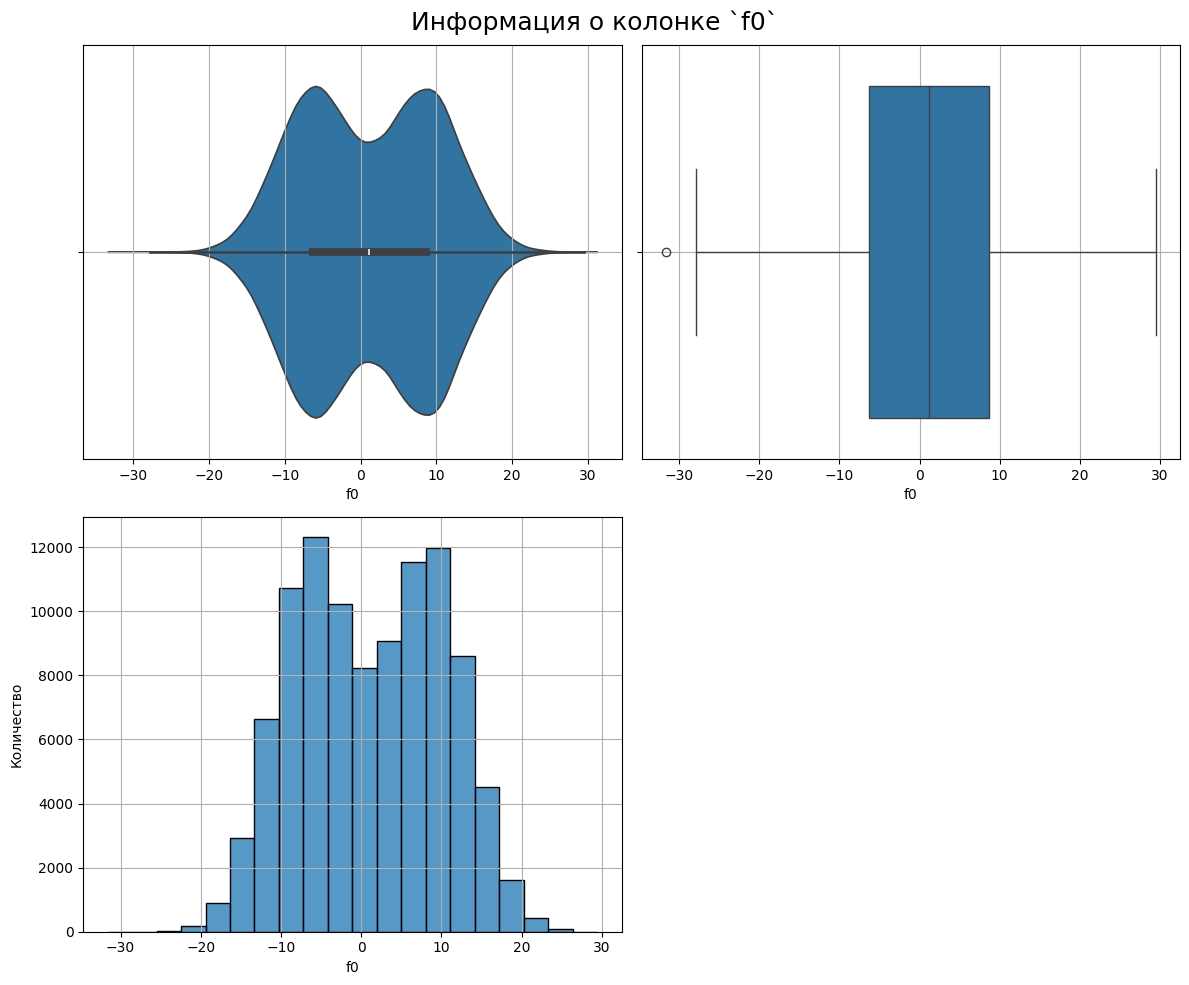

In [29]:
draw_plots_about_column(df1, 'f0', 'f0')

#### 3.5.2. <a id='toc3_5_2_'></a>Столбец `f1`      [&#8593;](#toc0_)

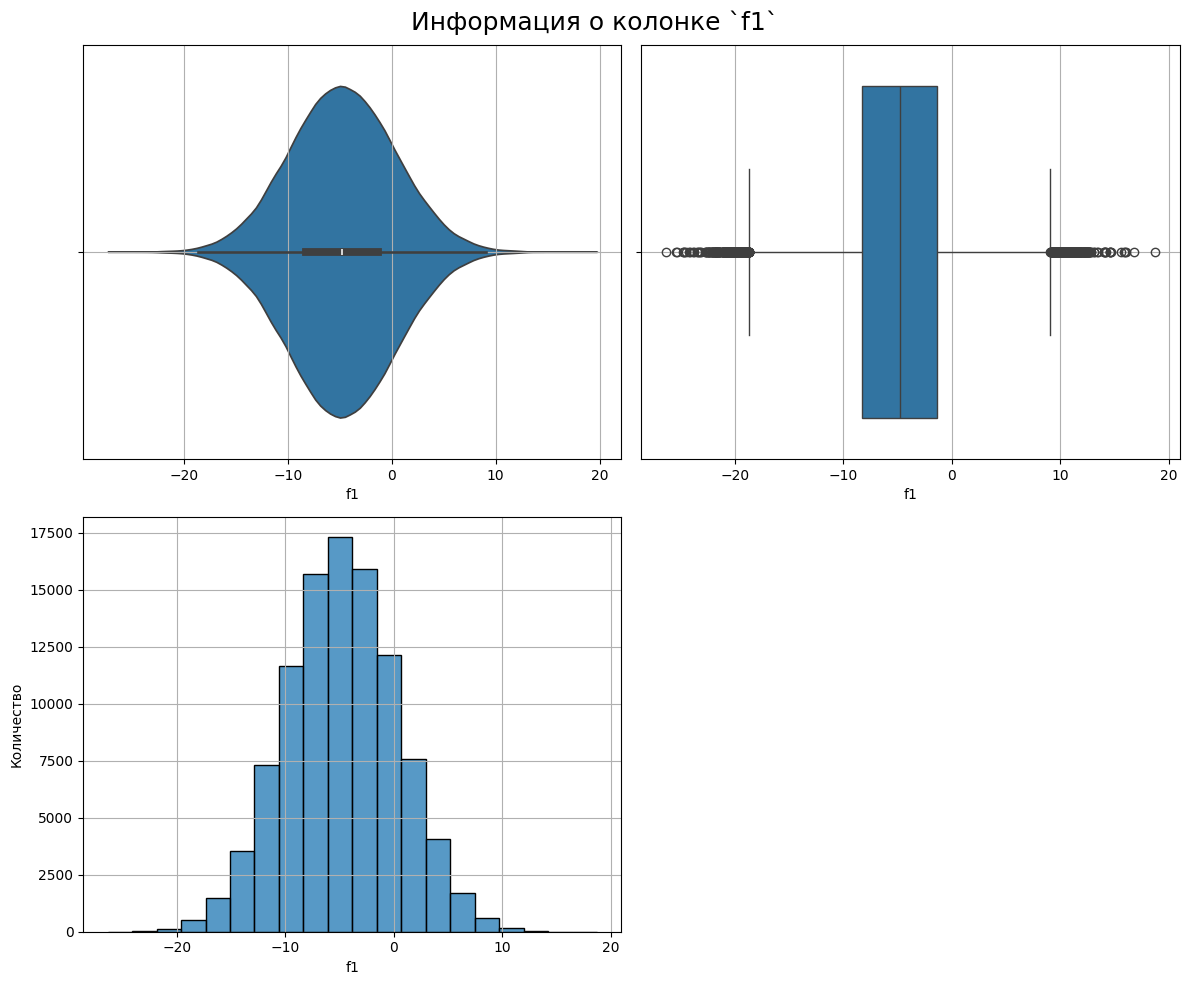

In [30]:
draw_plots_about_column(df1, 'f1', 'f1')

#### 3.5.3. <a id='toc3_5_3_'></a>Столбец `f2`      [&#8593;](#toc0_)

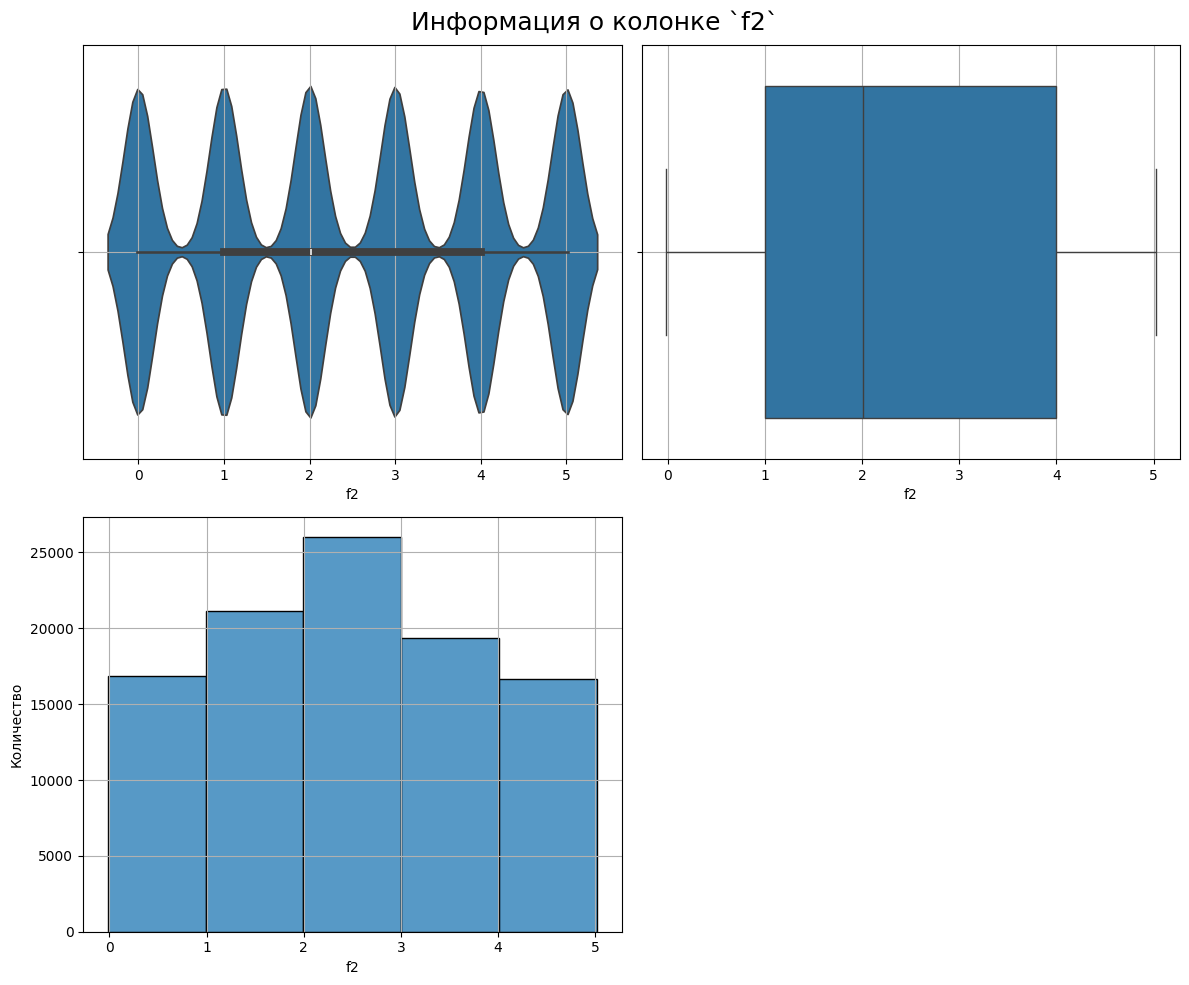

In [31]:
draw_plots_about_column(df1, 'f2', 'f2', bins=5)

#### 3.5.4. <a id='toc3_5_4_'></a>Столбец `product`      [&#8593;](#toc0_)

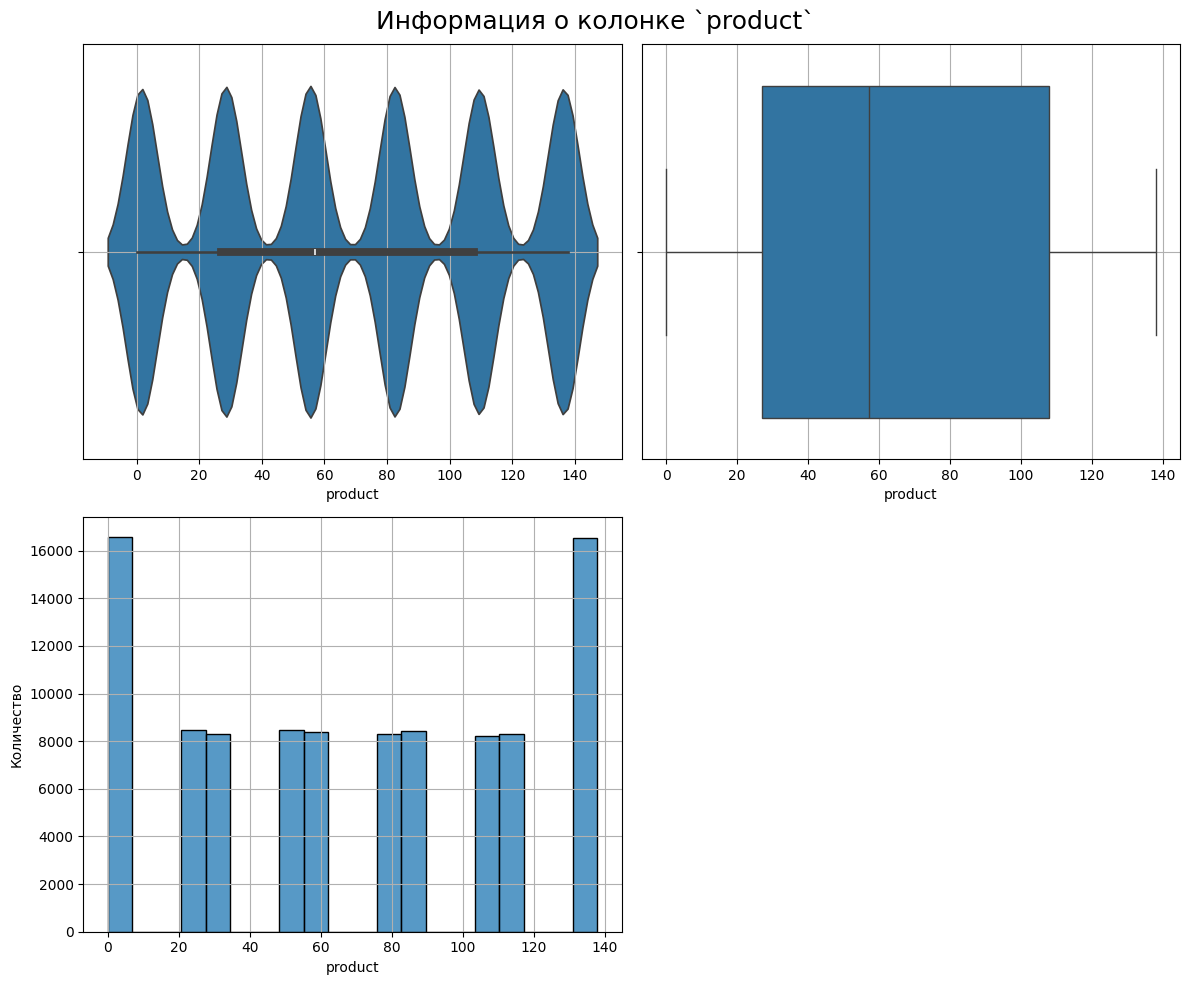

In [32]:
draw_plots_about_column(df1, 'product', 'product')

### 3.6. <a id='toc3_6_'></a>Проверка корреляции    [&#8593;](#toc0_)

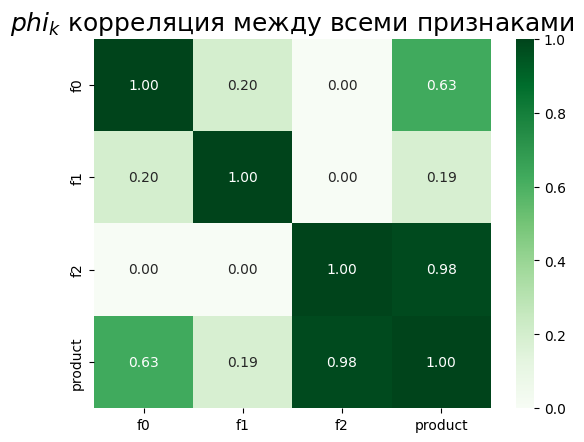

In [33]:
sns.heatmap(
    df1.phik_matrix(interval_cols=df1.columns),
    cmap='Greens',
    annot=True,
    fmt='.2f');

plt.title(r'$phi_k$ корреляция между всеми признаками', fontsize=18);

### 3.7. <a id='toc3_7_'></a>Проверка мультиколлинеарности    [&#8593;](#toc0_)

In [34]:
check_vif_values(df1, df1.columns)

,Variable,VIF
0,const,1.00
2,f1,1.05
1,f0,3.16
3,f2,2660.14
4,product,2662.65


### 3.8. <a id='toc3_8_'></a>Выводы по датасету      [&#8593;](#toc0_)

Датасет содержит информацию о скважинах в регионе 1. Датасет не имеет пропусков и полных дубликатов. Столбец `id` был удален, так как не несет никакой пользы. Все остальные столбцы - численные непрерывные. Признак `f1` имеет форму нормального распределения, все остальные - не имеют четкого выраженного распределения.

Наблюдаются странные значения для признака `f2`. Данный столбец имеет крайне высокую корреляцию с тартегом.

## 4. <a id='toc4_'></a>Данные о скважине 2      [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Загрузка      [&#8593;](#toc0_)

In [35]:
# dataset is not presented due to copyright
df2 = get_dataframe(['./data/geo_data_2.csv'])

df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


### 4.2. <a id='toc4_2_'></a>Проверка типов данных      [&#8593;](#toc0_)

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Типы данных указаны верно во всех столбцах.

### 4.3. <a id='toc4_3_'></a>Обработка дубликатов      [&#8593;](#toc0_)

In [37]:
df2.duplicated().sum()

0

Полных дубликатов нет. Столбец `id` не несет практической пользы, поэтому избавимся от него и снова проверим не появились ли дубликаты.

In [38]:
df2 = df2.drop(columns='id')

In [39]:
df2.duplicated().sum()

0

### 4.4. <a id='toc4_4_'></a>Обработка пропусков      [&#8593;](#toc0_)

In [40]:
print_table_about_nans(df2)

+---------+----------------------+
| Feature | Missing values count |
+---------+----------------------+
|    f0   |      0 (0.00%)       |
|    f1   |      0 (0.00%)       |
|    f2   |      0 (0.00%)       |
| product |      0 (0.00%)       |
+---------+----------------------+


Датасет не содержит пропусков.

### 4.5. <a id='toc4_5_'></a>Изучение столбцов      [&#8593;](#toc0_)

#### 4.5.1. <a id='toc4_5_1_'></a>Столбец `f0`      [&#8593;](#toc0_)

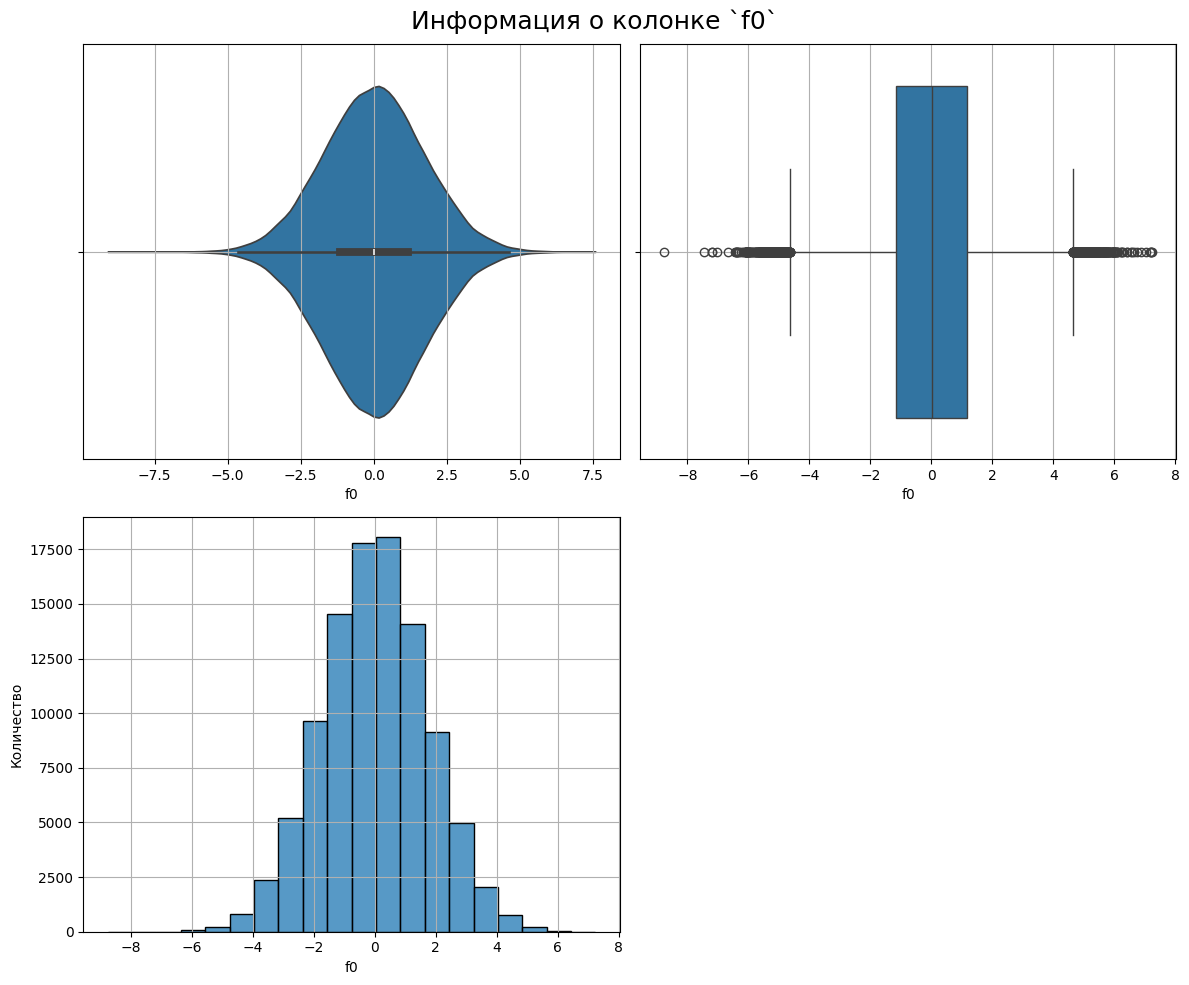

In [41]:
draw_plots_about_column(df2, 'f0', 'f0')

#### 4.5.2. <a id='toc4_5_2_'></a>Столбец `f1`      [&#8593;](#toc0_)

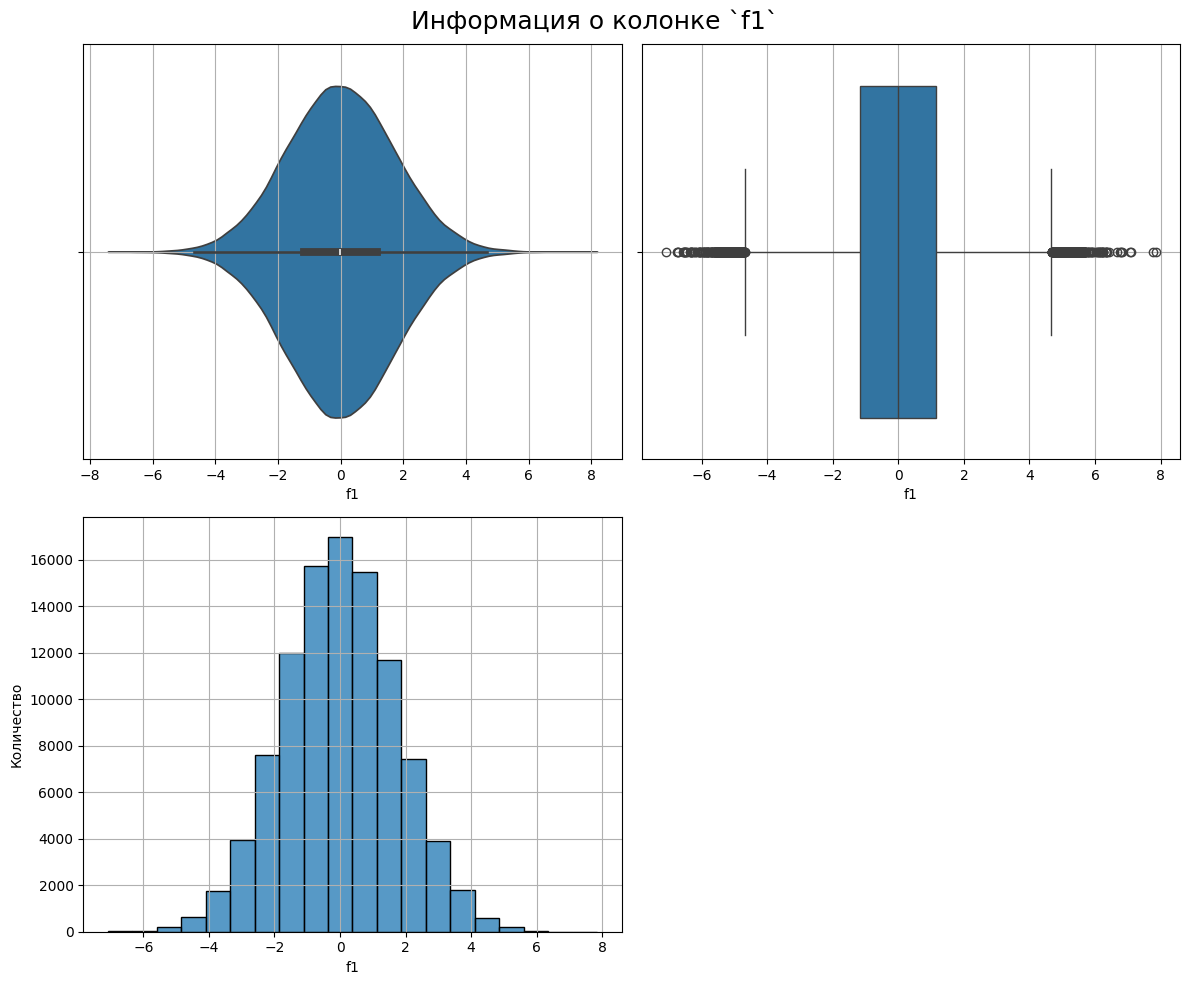

In [42]:
draw_plots_about_column(df2, 'f1', 'f1')

#### 4.5.3. <a id='toc4_5_3_'></a>Столбец `f2`      [&#8593;](#toc0_)

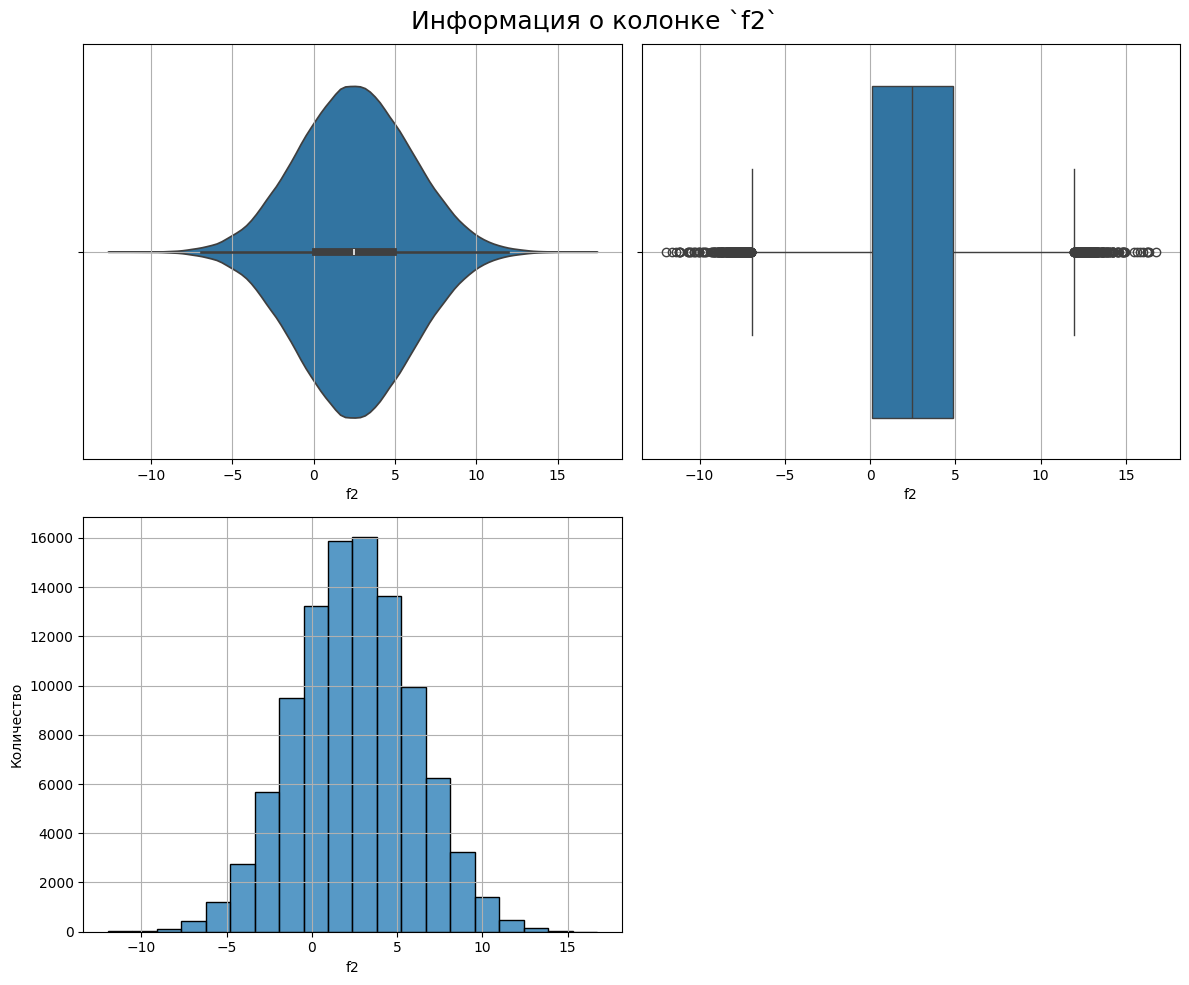

In [43]:
draw_plots_about_column(df2, 'f2', 'f2')

#### 4.5.4. <a id='toc4_5_4_'></a>Столбец `product`      [&#8593;](#toc0_)

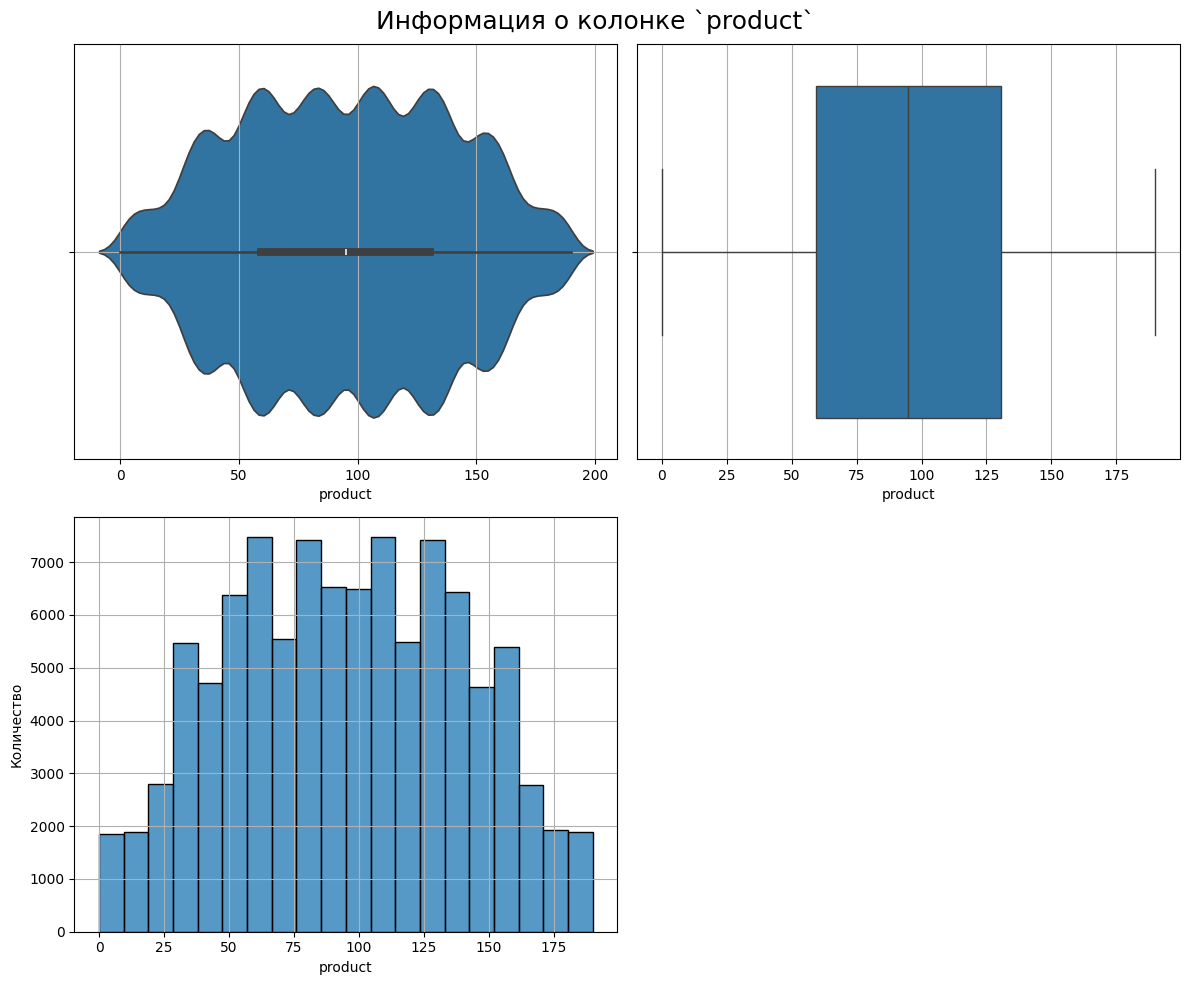

In [44]:
draw_plots_about_column(df2, 'product', 'product')

### 4.6. <a id='toc4_6_'></a>Проверка корреляции   [&#8593;](#toc0_)

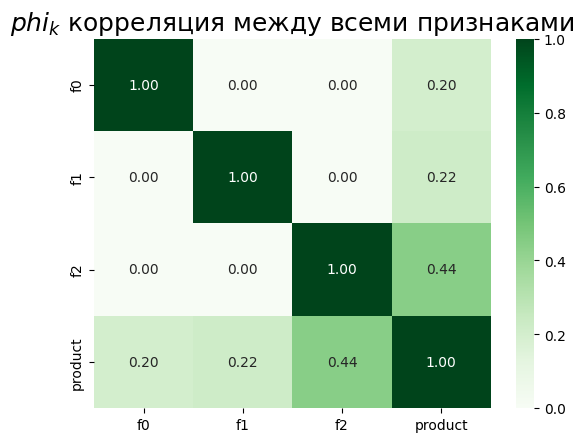

In [45]:
sns.heatmap(
    df2.phik_matrix(interval_cols=df2.columns),
    cmap='Greens',
    annot=True,
    fmt='.2f');

plt.title(r'$phi_k$ корреляция между всеми признаками', fontsize=18);

### 4.7. <a id='toc4_7_'></a>Проверка мультиколлинеарности   [&#8593;](#toc0_)

In [46]:
check_vif_values(df2, df2.columns)

,Variable,VIF
0,const,1.00
2,f1,1.00
1,f0,1.00
3,f2,1.25
4,product,1.25


### 4.8. <a id='toc4_8_'></a>Выводы по датасету      [&#8593;](#toc0_)

Датасет содержит информацию о скважинах в регионе 0. Датасет не имеет пропусков и полных дубликатов. Столбец `id` был удален, так как не несет никакой пользы. Все остальные столбцы - численные непрерывные. Все признаки `f0`, `f1` и `f2` имеют форму нормального распределения. Мультиколлинеарности нет.

## 5. <a id='toc5_'></a>Расчёт прибыли     [&#8593;](#toc0_)

In [47]:
target = 'product'

In [48]:
y_test0, y_pred0 = predict_result(df0, target)

Средний запас предсказанного сырья = 92.53
                              RMSE = 37.28


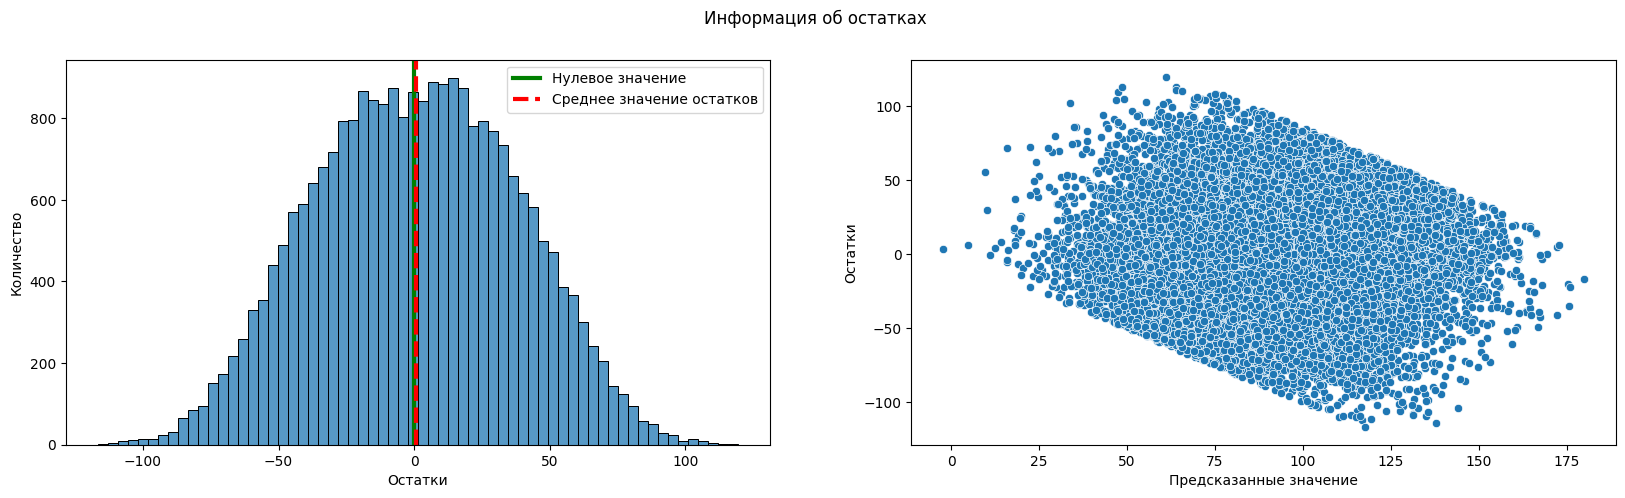

In [49]:
get_plots_about_residuals(y_test0, y_pred0)

---

In [50]:
y_test1, y_pred1 = predict_result(df1, target)

Средний запас предсказанного сырья = 68.89
                              RMSE =  0.90


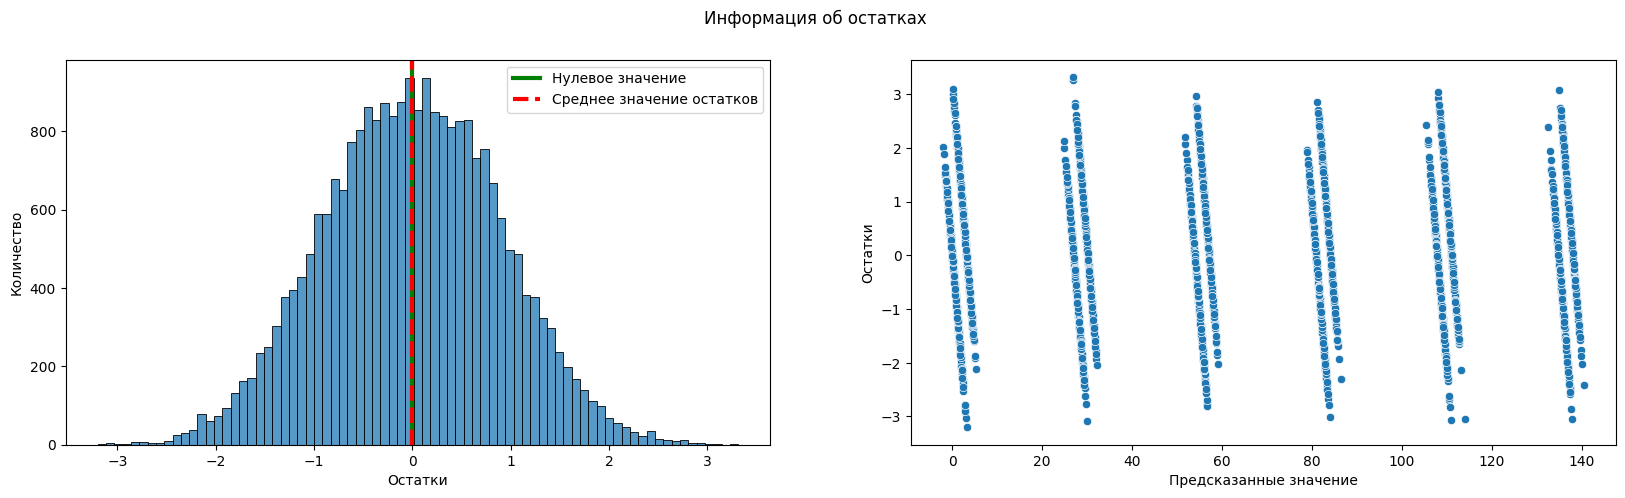

In [51]:
get_plots_about_residuals(y_test1, y_pred1)

---

In [52]:
y_test2, y_pred2 = predict_result(df2, target)

Средний запас предсказанного сырья = 94.97
                              RMSE = 40.06


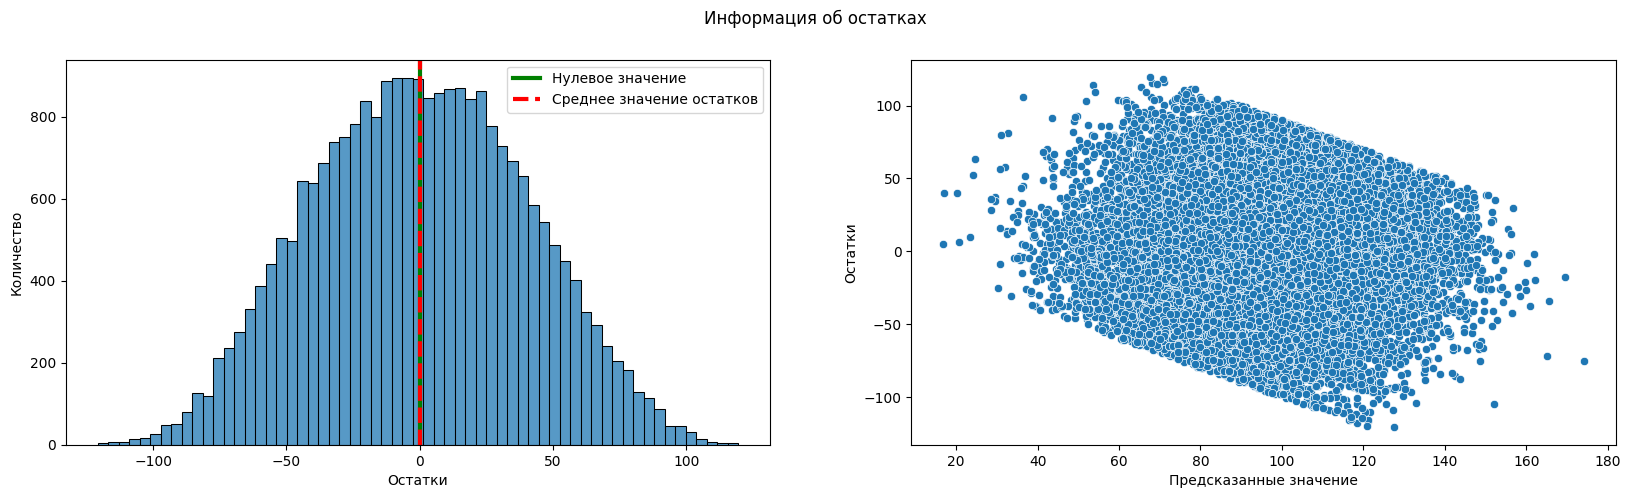

In [53]:
get_plots_about_residuals(y_test2, y_pred2)

---

В регионах 1 и 3 предсказаны более высокие значения, однако и ошибка на порядок выше. В регионе 1 предсказано более скромное значение, но и ошибка почти нулевая. Это связано с наличием признака `f2`, которые имеет крайне сильную корреляцию с таргетом в датасете 1 региона.

Анализ остатков говорит о том, что для регионов 0 и 2 модели имеют следующие тенденции:
- Для небольших предсказанных значений - истинное значение выше
- Для больших предсказанных значений - истинное значение ниже

Но в целом данные ошибки компенсируют друг друга, среднее значение остатков почти нулевое. Гистограмма остатков также подтверждает это, так как имеет нормальное распределение с центром в точке 0.

---

In [54]:
REVENUE_PER_UNIT = 450_000
DEVELOPMENT_BUDGET = 10_000_000_000
N_SELECT = 500
N_BEST = 200

In [55]:
print(f'Для безубыточной разработки необходимо иметь средний запас в {DEVELOPMENT_BUDGET / REVENUE_PER_UNIT / N_BEST:.0f} единиц продукта на каждой скважине.')

Для безубыточной разработки необходимо иметь средний запас в 111 единиц продукта на каждой скважине.


В среднем на скважинах запас меньше, чем рассчитанный. Однако мы будем выбирать лучшие скважины, поэтому, скорее всего разработка окажется прибыльной.

---

In [56]:
def analyze_region(y_true: pd.Series, y_pred: pd.Series) -> None:
    def get_revenue(y_true: pd.Series, y_pred: pd.Series) -> float:
        y_pred_sorted = y_pred.sort_values(ascending=False)
        y_true_sorted = y_true[y_pred_sorted.index]

        selected = y_true_sorted[:N_BEST]
        total_product_of_selected = selected.sum()

        return total_product_of_selected * REVENUE_PER_UNIT

    state = np.random.RandomState(RANDOM_STATE)
    values = []

    for _ in range(1000):
        y_true_subsample = y_true.sample(N_SELECT, replace=True, random_state=state)
        y_pred_subsample = y_pred[y_true_subsample.index]
        profit = get_revenue(y_true_subsample, y_pred_subsample) - DEVELOPMENT_BUDGET
        values.append(profit)

    values = pd.Series(values)

    print(f'Средняя прибыль: {values.mean():,.0f}'.replace(',', ' '))
    a, b = values.quantile([0.025, 0.975])
    print('95% Доверительный интервал прибыли: [{};\t{}]'.format(f'{a:,.0f}'.replace(',', ' '), f'{b:,.0f}'.replace(',', ' ')))

    prob = (values < 0).mean()

    print(f'Вероятность убыточности разработки региона: {prob:.1%}')

In [57]:
analyze_region(y_test0, y_pred0)

Средняя прибыль: 543 129 661
95% Доверительный интервал прибыли: [34 157 106;	1 082 684 486]
Вероятность убыточности разработки региона: 1.8%


In [58]:
analyze_region(y_test1, y_pred1)

Средняя прибыль: 512 262 559
95% Доверительный интервал прибыли: [83 810 515;	959 274 722]
Вероятность убыточности разработки региона: 0.7%


In [59]:
analyze_region(y_test2, y_pred2)

Средняя прибыль: 421 540 976
95% Доверительный интервал прибыли: [-136 392 325;	950 786 743]
Вероятность убыточности разработки региона: 6.5%


## 6. <a id='toc6_'></a>Общий вывод [&#8593;](#toc0_)

В рамках данного проекта требовалось проанализировать информацию о 3 различных регионах для добычи нефти. В каждом регионе есть скважины, о которых была представлена информация. Было необходимо выбрать один из 3 регионов для его дальнейшей разработки.

С помощью техники *Bootstrap* было найдено распределение прибыли. Из 500 случайных выбиралось 200 лучших по предсказанному количеству запасов. Во всех регионах средняя прибыль оказалась на уровне `400 - 500 млн`. Вероятность убыточности разработки составляет `1.8%`, `0.7%` и `6.5%` соответственно.

В итоге самыми привлекательными являются регионы 0 и 1. В них средняя прибыль равняется `543` и `512` млн рублей. Именно они рекомендуются для разработки.

В свою очередь регион 2 имеет слишком высокий шанс оказаться убыточным - `6.5%` при допустимом уровне риска в `2.5%`. Поэтому он не рекомендуется для разработки.